# <u><b>An Investigation Into Proportion of Urban Crimes Committed At Night</b></u>

In [2]:
# loading necessary libraries
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(dplyr)
library(gridExtra)
library(broom)

options(repr.matrix.max.rows = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## <u>Introduction</u>

An understanding of both the temporal and spatial patterns of criminal activity within cities is key to developing effective prevention and intervention strategies. Previous literature has shown that occurrences of crime are determined by urban spatial configuration[1] and that crime rates are negatively correlated to ambient light level[2]. As the third largest metropolitan area in Canada, crimes in Vancouver also reflect these patterns.

In our project, we are going to use publicly available crime data from the Vancouver Police Department[3] from April 2013 to April 2023. This data contains information for the type of crime, its date and time, and location. We intend to use this data to make an inference on what proportion of crimes happen at night. We will then use this proportion and its standard deviation to hypothesize whether there is a difference in nighttime crime rate between downtown and non-downtown areas for major cities across North America.

##  <u>Tidying Up the Data</u>

We want our data be easily usable, so we will:
- remove columns we don't need
- label crimes as either occuring in downtown (Central Business District, West End, Stanley Park, or Strathcona) or elsewhere
- label crimes as either occuring at night (5pm - 6am) or day

In [3]:
# load the data from github
crimedata_AllNBHD_23_13 <- read_csv(file = "https://raw.githubusercontent.com/AllenCheng5186/STAT201-Group16-Group-Project/main/data/crimedata_AllNeighbourhoods_23_13.csv")

crimedata_AllNBHD_23_13

Rows: 428271 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2023,2,22,12,12,YUKON ST / W BROADWAY AVE,Mount Pleasant,491786,5456719
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


In [6]:
# mutate two more colnumes of region (happen in downtown or not) and whether it is happen at night
crimedata_AllNBHD_23_13 <- crimedata_AllNBHD_23_13 |>
    select(!c('HUNDRED_BLOCK', 'X','Y')) |>
    mutate(YEAR = as.integer(YEAR), 
           MONTH = as.integer(MONTH), 
           DAY = as.integer(DAY),
           HOUR = as.integer(HOUR),
           MINUTE = as.integer(MINUTE)) |>
    arrange(by = desc(YEAR)) |>
    mutate(DOWNTOWN = NEIGHBOURHOOD %in% c("Central Business District", "West End", "Stanley Park", "Strathcona"),
           NIGHT = !(HOUR %in% c(6:17)))

crimedata_AllNBHD_23_13

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,NEIGHBOURHOOD,DOWNTOWN,NIGHT
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
Break and Enter Commercial,2023,9,14,3,32,West End,TRUE,TRUE
Break and Enter Commercial,2023,4,1,4,7,West End,TRUE,TRUE
Break and Enter Commercial,2023,4,3,0,50,Central Business District,TRUE,TRUE
Break and Enter Commercial,2023,5,11,18,0,Central Business District,TRUE,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2013,11,6,14,47,Mount Pleasant,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,23,13,31,Mount Pleasant,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,Riley Park,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,Riley Park,FALSE,FALSE


## <u>Preliminary Analysis</u>

### Part I: Comparing Crime Levels in Downtown to Other Parts of Vancouver

In [7]:
# summarize the count of incidents happen in two categories of region (downtwon & other)
criminedata_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(downtown = sum(DOWNTOWN),
              other = sum(!DOWNTOWN)) |>
    pivot_longer(cols = downtown:other, names_to = "region", values_to = "count")

criminedata_summary

YEAR,region,count
<int>,<chr>,<int>
2013,downtown,15198
2013,other,20573
2014,downtown,16613
2014,other,22592
⋮,⋮,⋮
2022,downtown,16186
2022,other,18070
2023,downtown,14504
2023,other,14892


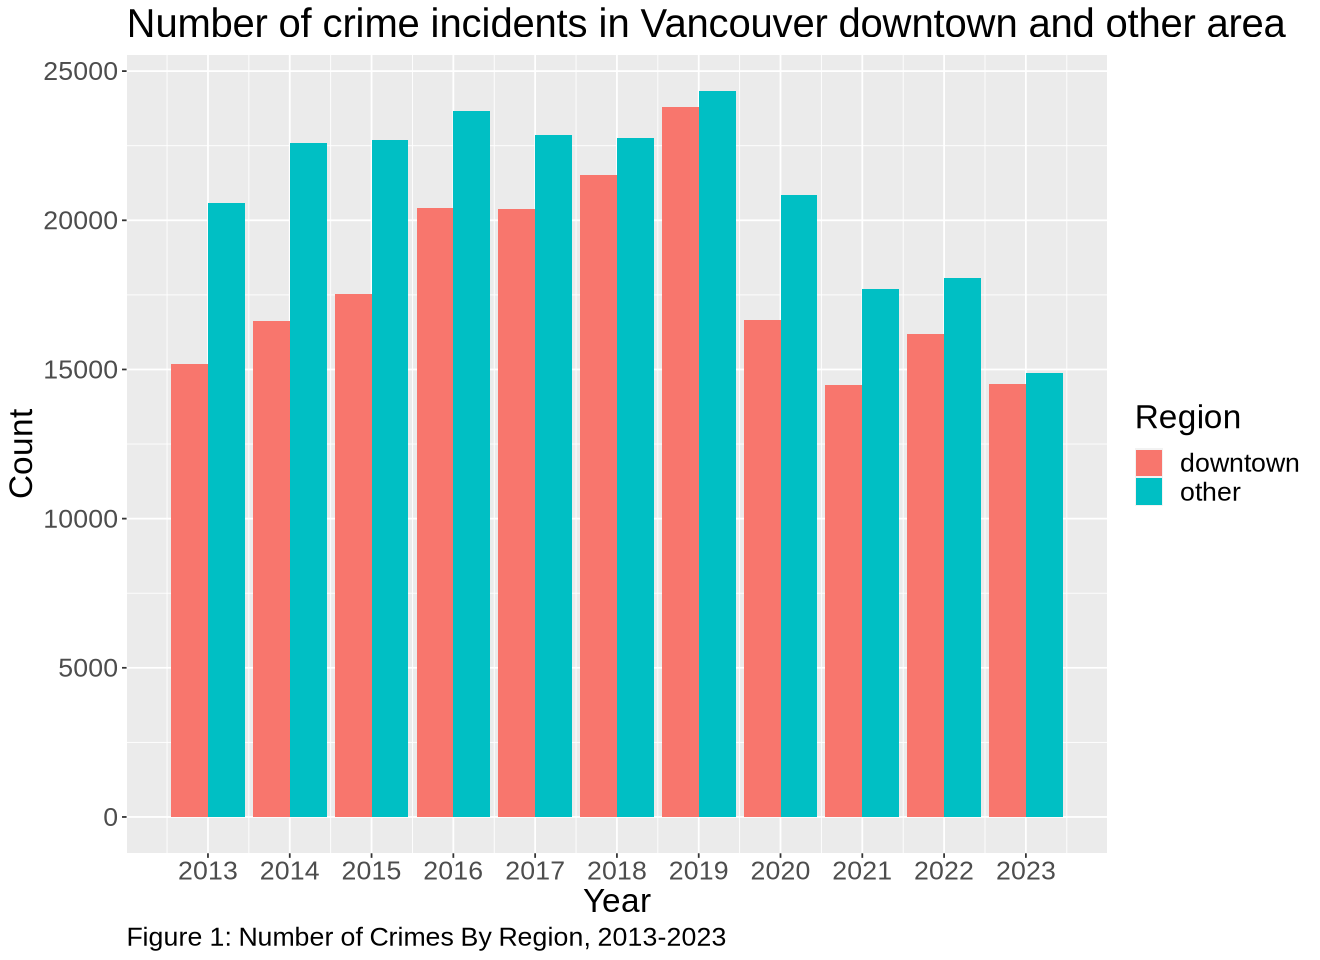

In [11]:
# visualize the count of incidents happen in two categories of area along time change
options(repr.plot.width = 11, repr.plot.height = 8)

crimedata_AllNBHD_23_13_barplot <-  criminedata_summary |>
    ggplot(aes(x = YEAR, y = count, fill = region)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Count", fill = "Region") +
    ggtitle("Number of crime incidents in Vancouver downtown and other area") +
    theme(text = element_text(size = 20)) + 
    labs(caption = "Figure 1: Number of Crimes By Region, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

crimedata_AllNBHD_23_13_barplot

We see that in general, more crime occurs in other parts of the city compared to downtown. There appears to be a steady growth in crime from 2013 - 2019, then a decline in crime till the present. The amount of crime in downtown varies from approximately 15000 - 23000, while the amount of crime in other parts of the city range from approximately 15000 - 24000.

### Part II: Comparing Daytime/Nighttime Crime Levels in Downtown to Other Parts of Vancouver

In [13]:
# summarize the count of the incidents happen in night or day (time) and downtown or non downtown (region)
criminedata_downtown_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(region = "downtown",
              aggregate = sum(DOWNTOWN),
              Night = sum(DOWNTOWN & NIGHT),
              Day = sum(DOWNTOWN & !NIGHT)) |>
    pivot_longer(cols = Night:Day, names_to = "time", values_to = "count")
criminedata_other_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(region = "other",
              aggregate = sum(!DOWNTOWN),
              Night = sum(!DOWNTOWN & NIGHT),
              Day = sum(!DOWNTOWN & !NIGHT)) |>
    pivot_longer(cols = Night:Day, names_to = "time", values_to = "count")

crime_AllNBHD_AllTime_summary <- bind_rows(criminedata_downtown_summary, criminedata_other_summary) |>
    arrange(YEAR)

crime_AllNBHD_AllTime_summary

YEAR,region,aggregate,time,count
<int>,<chr>,<int>,<chr>,<int>
2013,downtown,15198,Night,8392
2013,downtown,15198,Day,6806
2013,other,20573,Night,10804
2013,other,20573,Day,9769
⋮,⋮,⋮,⋮,⋮
2023,downtown,14504,Night,7893
2023,downtown,14504,Day,6611
2023,other,14892,Night,8086
2023,other,14892,Day,6806


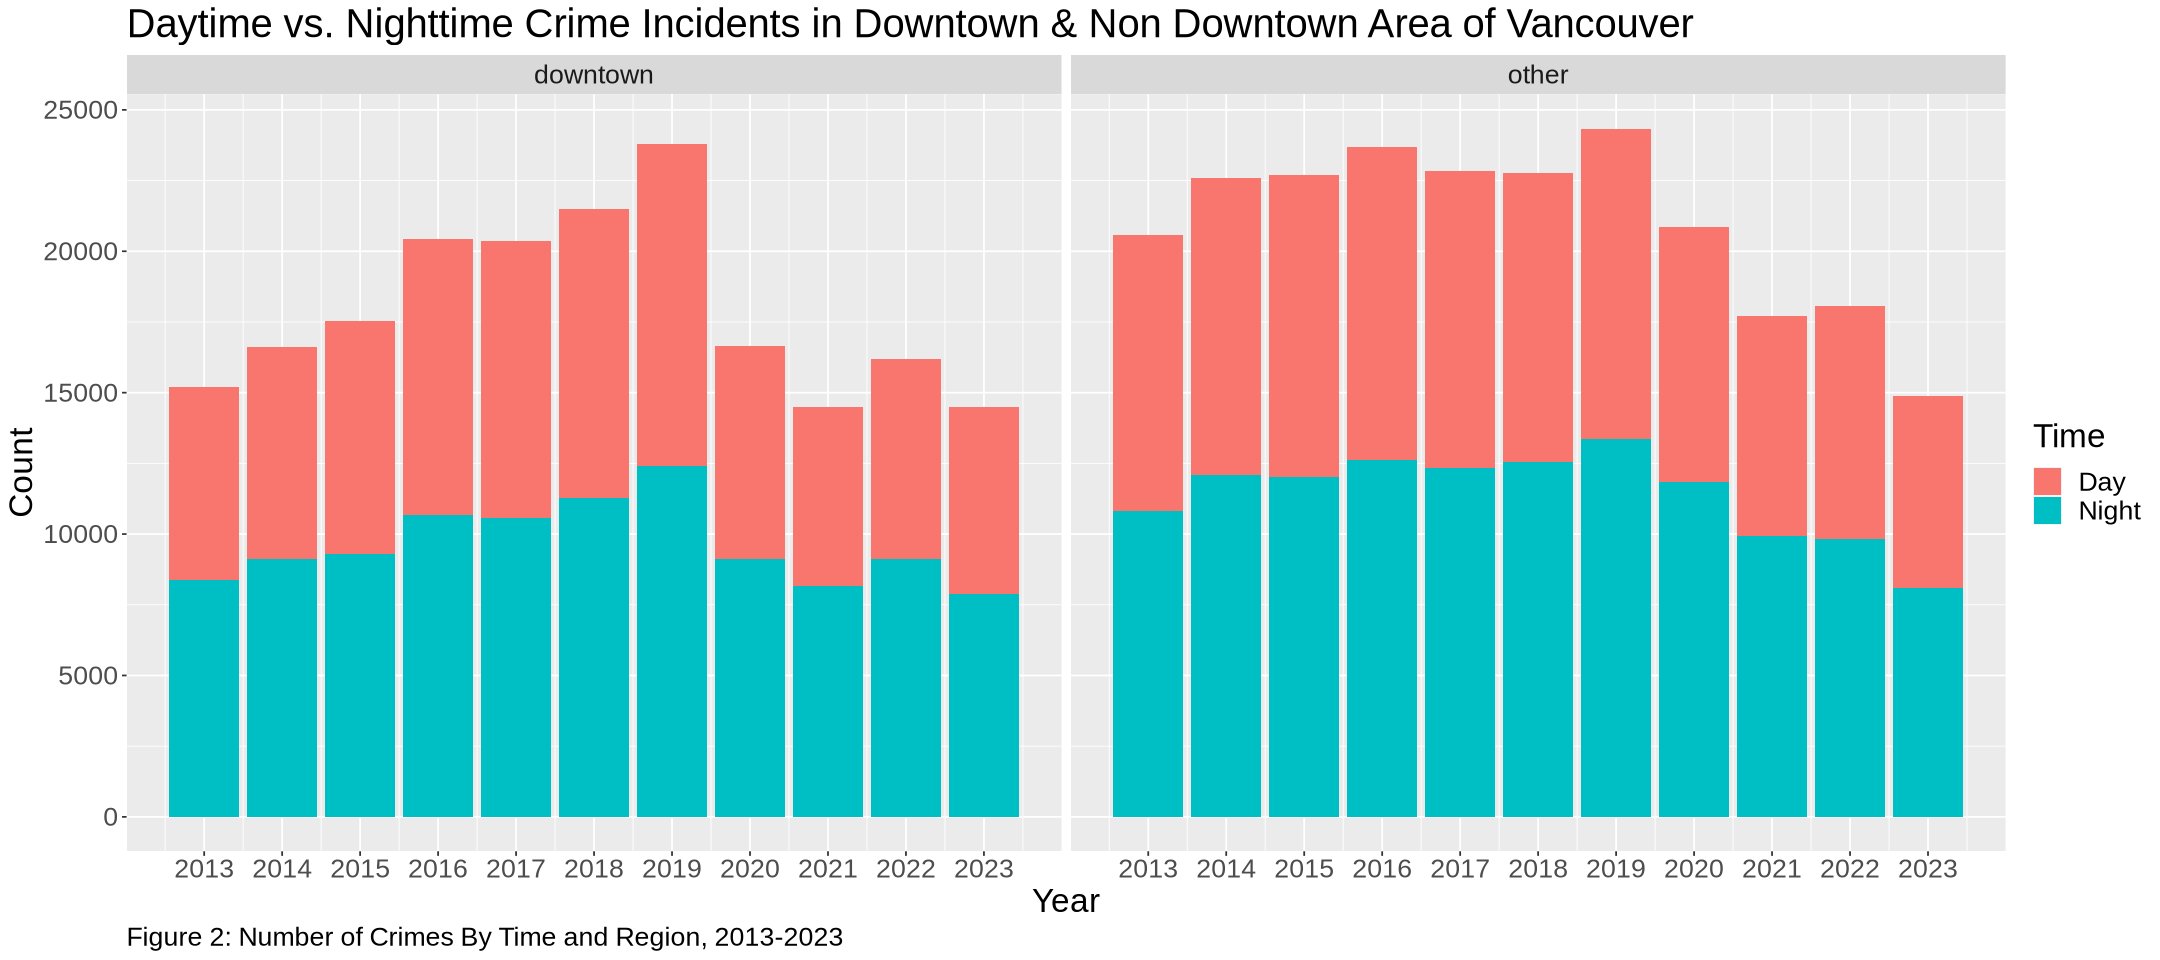

In [14]:
# visualize the count of crimes happened in the two time periods and regions along the years
options(repr.plot.width = 18, repr.plot.height = 8)

crime_AllNBHD_AllTime_summary_bar <- crime_AllNBHD_AllTime_summary |>
    ggplot(aes(x = YEAR, y = count, fill = time)) +
    geom_bar(stat = "identity") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Count", fill = "Time") +
    ggtitle("Daytime vs. Nighttime Crime Incidents in Downtown & Non Downtown Area of Vancouver") +
    theme(text = element_text(size = 20)) +
    facet_grid(cols = vars(region)) + 
    labs(caption = "Figure 2: Number of Crimes By Time and Region, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

crime_AllNBHD_AllTime_summary_bar

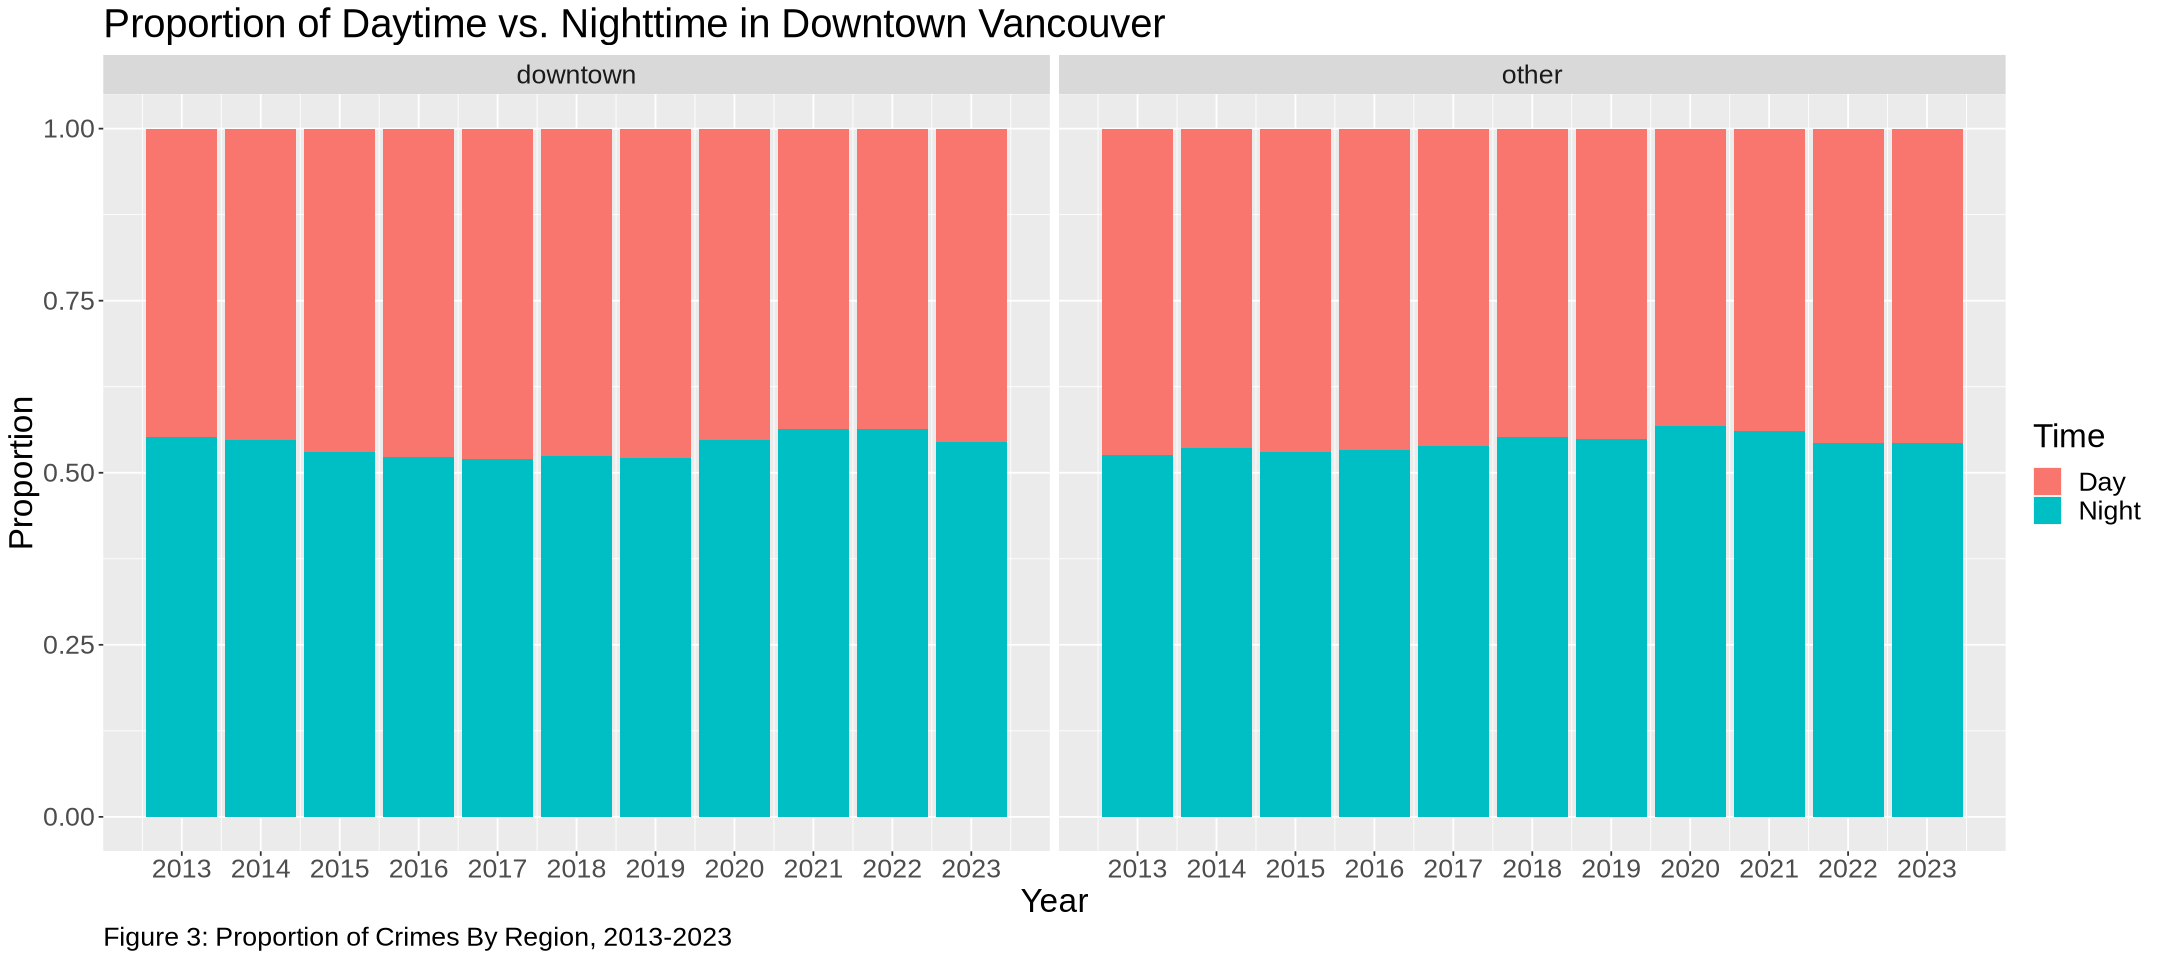

In [15]:
# visualize the proportion of the crimes happened at night or day in two regions
options(repr.plot.width = 18, repr.plot.height = 8)
crime_AllNBHD_AllTime_summary_prop <- crime_AllNBHD_AllTime_summary |>
    ggplot(aes(x = YEAR, y = count, fill = time)) +
    geom_bar(stat = "identity",position = "fill") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Proportion", fill = "Time") +
    ggtitle("Proportion of Daytime vs. Nighttime in Downtown Vancouver") +
    theme(text = element_text(size = 20)) +
    facet_grid(cols = vars(region)) + 
    labs(caption = "Figure 3: Proportion of Crimes By Region, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

crime_AllNBHD_AllTime_summary_prop

For both downtown and non-downtown, the proportion of crimes that occur at night is a little above 50%. This value seems to fluctuate a little bit every year but seems constant.

In [9]:
# calculate the sample statistics of average count and overall proportion for past 10 years average
crime_average <- crime_AllNBHD_AllTime_summary |>
    group_by(region, time) |>
    summarize(average = round(mean(count))) |>
    ungroup() |>
    mutate(prop = average/sum(average))

crime_average

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


region,time,average,prop
<chr>,<chr>,<dbl>,<dbl>
downtown,Day,8293,0.2130015
downtown,Night,9640,0.2475985
other,Day,9594,0.2464170
other,Night,11407,0.2929830


## <u>Taking a Sample</u>

We have access to the entire population because this crime data is publicly available and regularly updated. However, as we've seen above, there don't appear to be a significant difference in the ratio of crimes committed in downtown/non-downtown over the last 10 years. Additionally, the proportion of crime committed at night in both downtown/non-downtown is mostly consistent every year. For these reasons, we will use all the crime data for 2022 (because it's the most recent completed year) as our sample. Below is a brief analysis about the sample:

In [10]:
# since the 2023 data is not completed, we will focus on 2022 data and use as our sample
crime_sample <- crimedata_AllNBHD_23_13 |>
    filter(YEAR == 2022)

crime_sample

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,NEIGHBOURHOOD,DOWNTOWN,NIGHT
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
Break and Enter Commercial,2022,1,5,7,34,West End,TRUE,FALSE
Break and Enter Commercial,2022,1,3,16,19,West End,TRUE,FALSE
Break and Enter Commercial,2022,6,17,5,16,West End,TRUE,TRUE
Break and Enter Commercial,2022,3,15,5,14,West End,TRUE,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2022,4,16,19,37,Renfrew-Collingwood,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,9,9,18,46,Hastings-Sunrise,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,8,31,20,1,Arbutus Ridge,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,10,12,8,27,Mount Pleasant,FALSE,FALSE


In [11]:
# overview of sample (2022) statistics 
crime_sample_summary <- crime_sample |>
    group_by(DOWNTOWN) |>
    summarize(aggregate = n(),
              night = sum(NIGHT),
              day = sum(!NIGHT)) |>
    pivot_longer(cols = night:day, names_to = "time", values_to = "count")

crime_sample_summary

DOWNTOWN,aggregate,time,count
<lgl>,<int>,<chr>,<int>
FALSE,18070,night,9828
FALSE,18070,day,8242
TRUE,16186,night,9118
TRUE,16186,day,7068


In [16]:
# visualize sample statistics distribution 

crime_sample_summary_count_dist <- crime_sample_summary |>
    ggplot(aes(x = DOWNTOWN, y = count, fill = time)) +
    geom_bar(stat = "identity") +
    labs(x = "Region (Downtown)", y = "Count", fill = "Time") +
    ggtitle("Sample counts region vs time distribution") +
    theme(text = element_text(size = 20)) + 
    labs(caption = "Figure 4: Number of Crimes By Time and Region, 2022") +
    theme(plot.caption = element_text(hjust = 0))
crime_sample_summary_prop_dist <- crime_sample_summary |>
    ggplot(aes(x = DOWNTOWN, y = count, fill = time)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Region (Downtown)", y = "Count", fill = "Time") +
    ggtitle("Sample proportion region vs time distribution") +
    theme(text = element_text(size = 20)) + 
    labs(caption = "Figure 5: Proportion of Crimes By Time and Region, 2022") +
    theme(plot.caption = element_text(hjust = 0))

options(repr.plot.width = 15, repr.plot.height = 8)
plot_grid(crime_sample_summary_count_dist,
          crime_sample_summary_prop_dist,
          ncol = 2)

ERROR: Error in ggplot(crime_sample_summary, aes(x = DOWNTOWN, y = count, fill = time)): object 'crime_sample_summary' not found


On the left graph, we see that more crime occurs in non-downtown areas for both daytime and nighttime. On the right, we see that downtown has a slightly more crime that occurs during the night, but we are unsure whether there is a significant difference.

## <u>Hypothesis Testing</u>

Below are the summary statistics for nighttime crime in downtown and non-downtown areas. We are trying to find out whether there is a significant difference between these two values, so we will use R's built-in prop.test function to do the statistical test for us. Since we want to know if these values are equal, this is a two sided test. We will also obtain a confidence interval for the difference between nighttime crime in downtown and non-downtown areas. There is only 1 test, so we will not use a continuity correction. Here is our null and alternative hypothesis:

$$H_0: P_{downtown-night-crime} = P_{non-downtown-night-crime}$$
$$H_a: P_{downtown-night-crime} \neq P_{non-downtown-night-crime}$$

In [18]:
# getting number of nighttimes and total crimes per area
crime_sample_summary <- crime_sample_summary |>
    group_by(DOWNTOWN) |>
    mutate(prop = count /sum(count)) |>
    filter(time == 'night')

crime_sample_summary

DOWNTOWN,aggregate,time,count,prop
<lgl>,<int>,<chr>,<int>,<dbl>
FALSE,18070,night,9828,1
TRUE,16186,night,9118,1


In [20]:
# two-tailed test on two proportions 
results <- tidy(
    prop.test(x = c(9118, 9828), 
              n = c(16186, 18070), 
              alternative = "two.sided", 
              conf.level = 0.9, 
              correct = F)
)
results

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.5633263,0.5438849,13.05565,0.0003023712,1,0.01059491,0.02828797,2-sample test for equality of proportions without continuity correction,two.sided


In [23]:
# obtaining the p-value from the statistical test
p_value <- results |>
    select(p.value) |>
    pull()
p_value

[1] 0.0003023712

## <u>Conducting More Hypothesis Tests</u>

In addition to the hypothesis test above for 2022, we have also conducted hypothesis tests for each year in our data. We are still trying to determine whether the true proportion of nighttime crime differs between downtown and non-downtown areas. We will construct 10 confidence intervals and 10 p-values. We will then use an $\alpha = 0.05$ to determine whether we will reject the null hypothesis.

In [1]:
options(repr.matrix.max.rows = 11)

alpha <- 0.05

prop_test_13_23 <- crime_AllNBHD_AllTime_summary |>
    filter(time == "Night") |>
    pivot_wider(names_from = region, values_from = c(aggregate, count)) |>
    select(YEAR, time, aggregate_downtown, count_downtown, aggregate_other, count_other) |>
    rowwise() |>
    group_by(YEAR) |>
    summarize(prop_test = list(tidy(prop.test(x = c(count_downtown, count_other), 
                                      n = c(aggregate_downtown, aggregate_other), 
                                      alternative = "two.sided", 
                                      conf.level = 0.9, 
                                      correct = F)))) |>
    pull(prop_test) |>
    bind_rows() |>
    mutate(year = seq(2013, 2023)) |>
    select(year, estimate1:conf.high, alternative) |>
    mutate(reject = p.value < alpha)

prop_test_13_23

ERROR: Error in mutate(select(mutate(bind_rows(pull(summarize(group_by(rowwise(select(pivot_wider(filter(crime_AllNBHD_AllTime_summary, : could not find function "mutate"


## <u>Methods</u>
We have a large sample size (428k) and we use well established statistical methods to draw our conclusions, which make this report trustworthy.

The main downside is the data is only from Vancouver, so we will apply our results to cities similar to Vancouver, which we defined as all Major North American Metropolitan Cities. From our plots we can see that between different years, the number/proportion of crimes varies, so we will only use the data from recent years, since that data will be most similar to the near future. We will use a hypothesis test to see if the proportion(night crimes/total crimes) differs between the downtown and non downtown areas, to see if this has an effect on the proportion. We will also be creating a bootstrap confidence interval(CI) and if possible a theory based CI to give a plausible range of values for what the true proportion could be will be since our data comes from a sample, we need to take into account the effect of sampling variation [4], 

We would expect to find that the proportion of crimes that occur at night to be quite close to 50%, with a slight bias towards >50%. We also expect that the proportion of crimes that occur downtown at night to be higher than other areas, given that typically downtown areas have more of a nightlife

The impact of our findings could be that police use it to decide where its best to allocate police resources.

A future question that we could have would be looking at the same proportions, but for each category of crime, since police often work in different units, so we can allocate specialized police resources where they’re most needed.


## <u>References</u>

[1] Schnelle, J. F., Kirchner, R. E., Casey, J. D., Uselton, P. H., &amp; McNees, M. P. (1977). Patrol Evaluation Research: A multiple-baseline analysis of saturation police patrolling during day and night hours. Journal of Applied Behavior Analysis, 10(1), 33–40. https://doi.org/10.1901/jaba.1977.10-33 

[2] Domínguez, P., &amp; Asahi, K. (2022). Crime-time: How ambient light affects crime. Journal of Economic Geography, 23(2), 299–317. https://doi.org/10.1093/jeg/lbac011 

[3] Vancouver Police Department. (n.d.). Crime Data Download. VPD open data. https://geodash.vpd.ca/opendata/ 

[4] “Apa Dictionary of Psychology.” American Psychological Association, American Psychological Association, dictionary.apa.org/sampling-variability. Accessed 4 Nov. 2023. 